In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

## 1. Get the data 

In [2]:
data = sm.datasets.co2.load_pandas().data
data

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
...,...
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2
2001-12-22,371.3


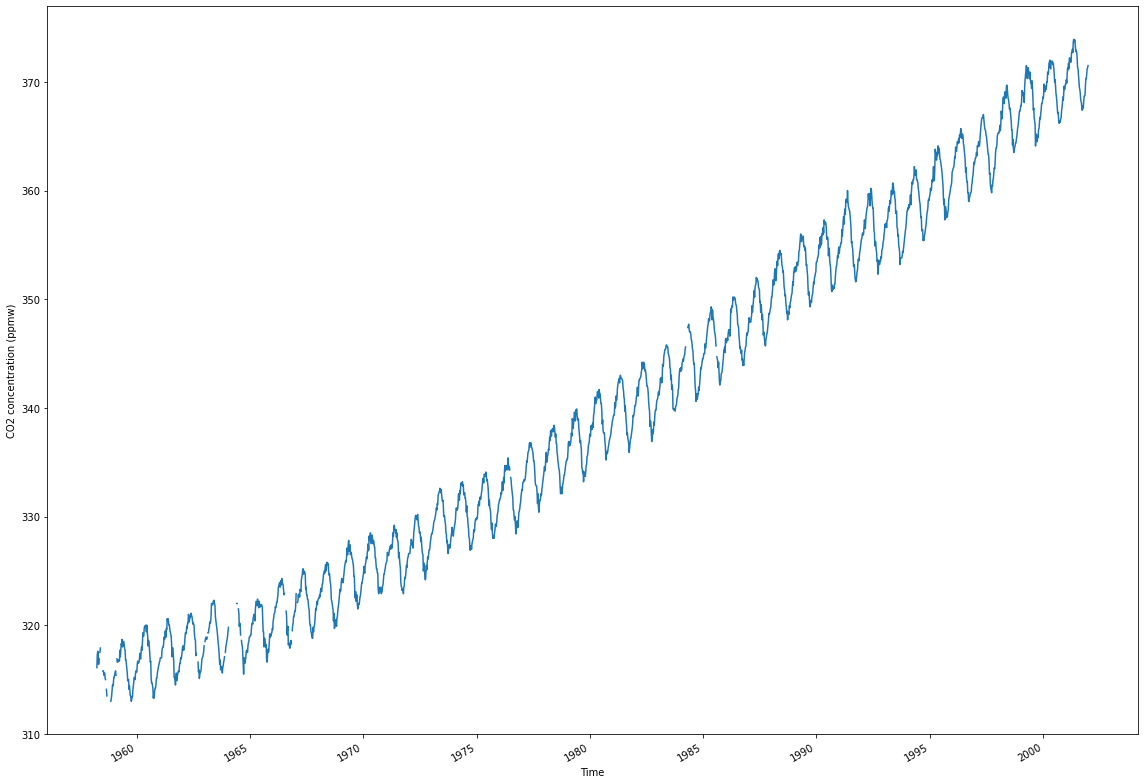

In [3]:
fig, ax = plt.subplots(figsize=(16, 11))

ax.plot(data['co2'])
ax.set_xlabel('Time')
ax.set_ylabel('CO2 concentration (ppmw)')

fig.autofmt_xdate()
plt.tight_layout()

## 2. Preprocess the data 

In [4]:
data.isnull().sum()

co2    59
dtype: int64

In [5]:
data = data.interpolate()

In [6]:
data.isnull().sum()

co2    0
dtype: int64

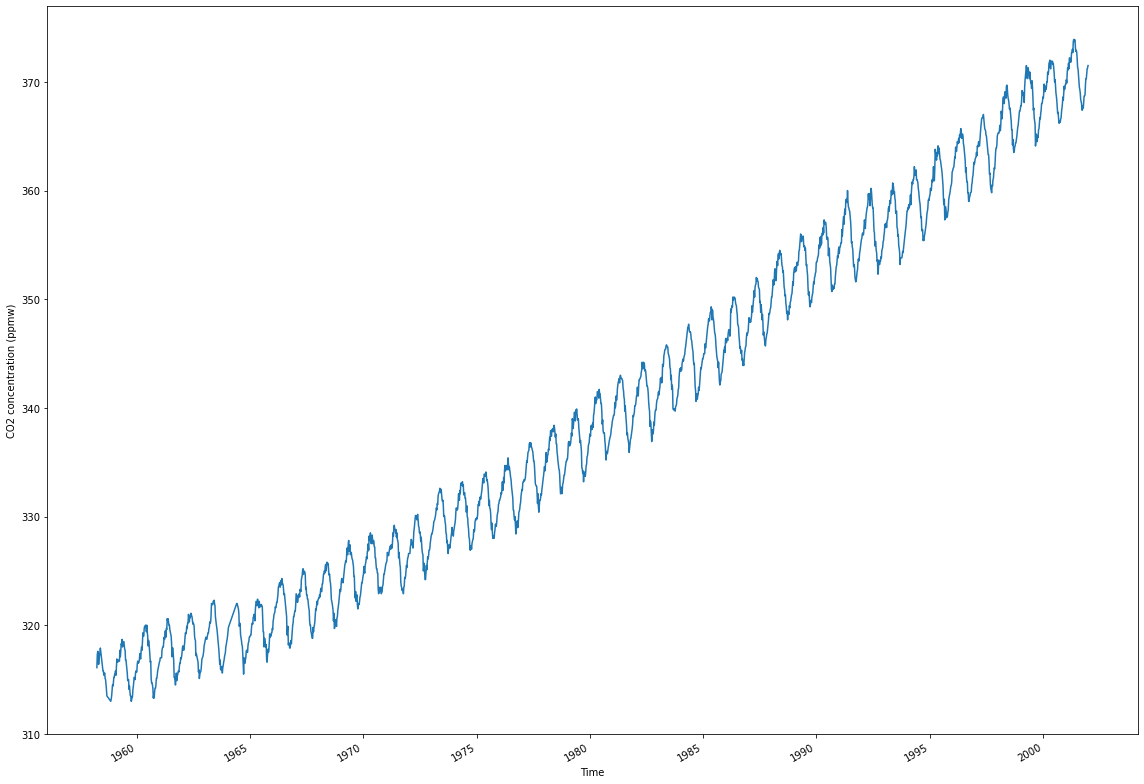

In [7]:
fig, ax = plt.subplots(figsize=(16, 11))

ax.plot(data['co2'])
ax.set_xlabel('Time')
ax.set_ylabel('CO2 concentration (ppmw)')

fig.autofmt_xdate()
plt.tight_layout()

## 3. Model
### 3.1 Baseline

In [8]:
train = data[:-104]
test = data[-104:]

print(f'Shape of training set: {train.shape}')
print(f'Shape of test set: {test.shape}')

Shape of training set: (2180, 1)
Shape of test set: (104, 1)


In [9]:
test.loc[:, 'baseline_pred'] = train['co2'][-104:].values
test.head()

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,co2,baseline_pred
2000-01-08,368.5,365.3
2000-01-15,369.0,365.3
2000-01-22,369.8,365.3
2000-01-29,369.2,365.6
2000-02-05,369.1,366.0


In [10]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

In [11]:
mape_baseline = mape(test['co2'], test['baseline_pred'])

print(f'{mape_baseline}%')

0.72%


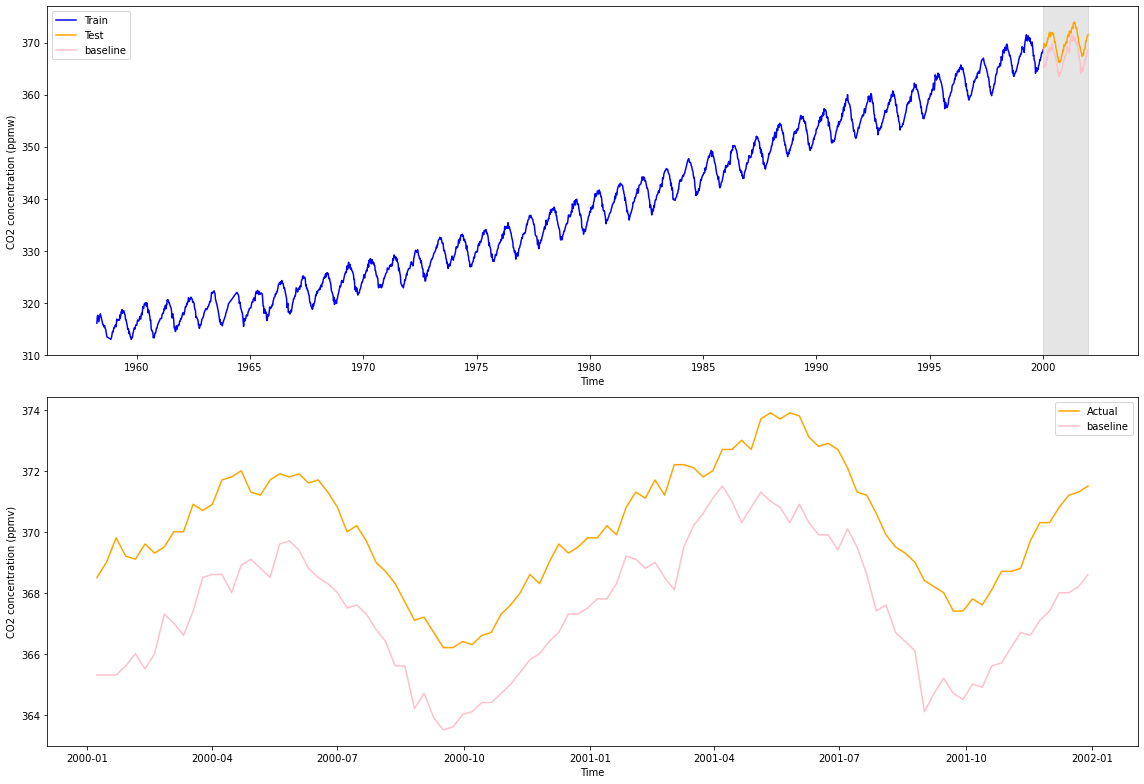

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 11))

ax1.plot(train['co2'], label='Train', color='blue')
ax1.plot(test['co2'], label='Test', color='orange')
ax1.plot(test['baseline_pred'], label='baseline', color='pink', ls='-')
ax1.legend(loc='best')
ax1.set_xlabel('Time')
ax1.set_ylabel('CO2 concentration (ppmw)')
ax1.axvspan('2000-01-08', '2001-12-29', color='#808080', alpha=0.2)

ax2.plot(test['co2'], label='Actual', color='orange')
ax2.plot(test['baseline_pred'], label='baseline', color='pink', ls='-')
ax2.legend(loc='best')
ax2.set_xlabel('Time')
ax2.set_ylabel('CO2 concentration (ppmv)')

plt.tight_layout()

### 3.2 Simple exponential smoothing

In [13]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

ses = SimpleExpSmoothing(train, initialization_method='estimated').fit()

In [14]:
print(f"alpha = {ses.model.params['smoothing_level']}")

alpha = 0.9999999849590426


In [15]:
ses_pred = ses.forecast(104)

In [16]:
test.loc[:, 'ses_pred'] = ses_pred
test.head()

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,co2,baseline_pred,ses_pred
2000-01-08,368.5,365.3,368.6
2000-01-15,369.0,365.3,368.6
2000-01-22,369.8,365.3,368.6
2000-01-29,369.2,365.6,368.6
2000-02-05,369.1,366.0,368.6


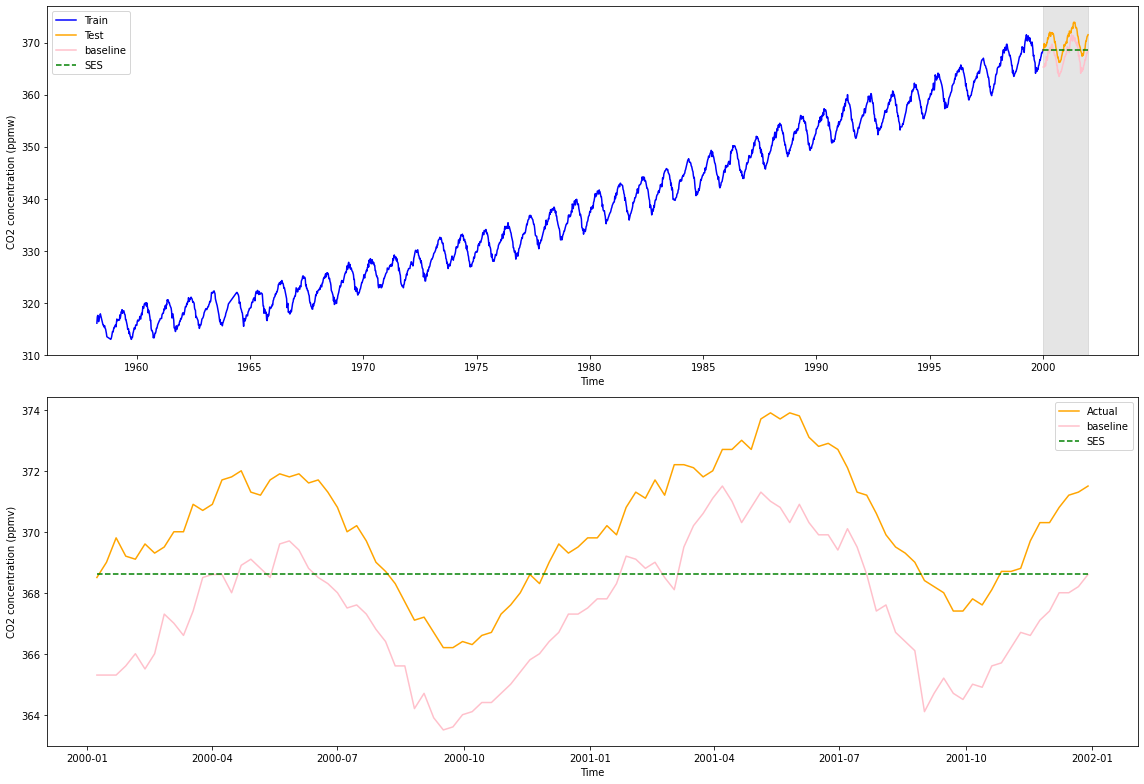

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 11))

ax1.plot(train['co2'], label='Train', color='blue')
ax1.plot(test['co2'], label='Test', color='orange')
ax1.plot(test['baseline_pred'], label='baseline', color='pink', ls='-')
ax1.plot(test['ses_pred'], label='SES', color='green', ls='--')
ax1.legend(loc='best')
ax1.set_xlabel('Time')
ax1.set_ylabel('CO2 concentration (ppmw)')
ax1.axvspan('2000-01-08', '2001-12-29', color='#808080', alpha=0.2)

ax2.plot(test['co2'], label='Actual', color='orange')
ax2.plot(test['baseline_pred'], label='baseline', color='pink', ls='-')
ax2.plot(test['ses_pred'], label='SES', color='green', ls='--')
ax2.legend(loc='best')
ax2.set_xlabel('Time')
ax2.set_ylabel('CO2 concentration (ppmv)')

plt.tight_layout()

In [18]:
ses_mape = mape(test['co2'], test['ses_pred'])

print(f'{ses_mape}%')

0.56%


### 3.3 Double exponential smoothing 

In [19]:
from statsmodels.tsa.holtwinters import Holt

des1 = Holt(train['co2'], exponential=False, damped_trend=False, initialization_method='estimated').fit()
des2 = Holt(train['co2'], exponential=False, damped_trend=True, initialization_method='estimated').fit()

In [20]:
print(f"alpha = {des1.model.params['smoothing_level']}")
print(f"beta = {des1.model.params['smoothing_trend']}")
print('------------------------')
print(f"alpha = {des2.model.params['smoothing_level']}")
print(f"beta = {des2.model.params['smoothing_trend']}")

alpha = 0.6677251439160768
beta = 0.3743639988794559
------------------------
alpha = 0.6263686279400204
beta = 0.4171221925831954


In [21]:
des1_pred = des1.forecast(104)
des2_pred = des2.forecast(104)

In [22]:
test.loc[:, 'des1_pred'] = des1_pred
test.loc[:, 'des2_pred'] = des2_pred

test.head()

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,co2,baseline_pred,ses_pred,des1_pred,des2_pred
2000-01-08,368.5,365.3,368.6,368.856000,368.744102
2000-01-15,369.0,365.3,368.6,369.134745,368.930371
2000-01-22,369.8,365.3,368.6,369.413490,369.096162
2000-01-29,369.2,365.6,368.6,369.692235,369.243727
2000-02-05,369.1,366.0,368.6,369.970980,369.375068


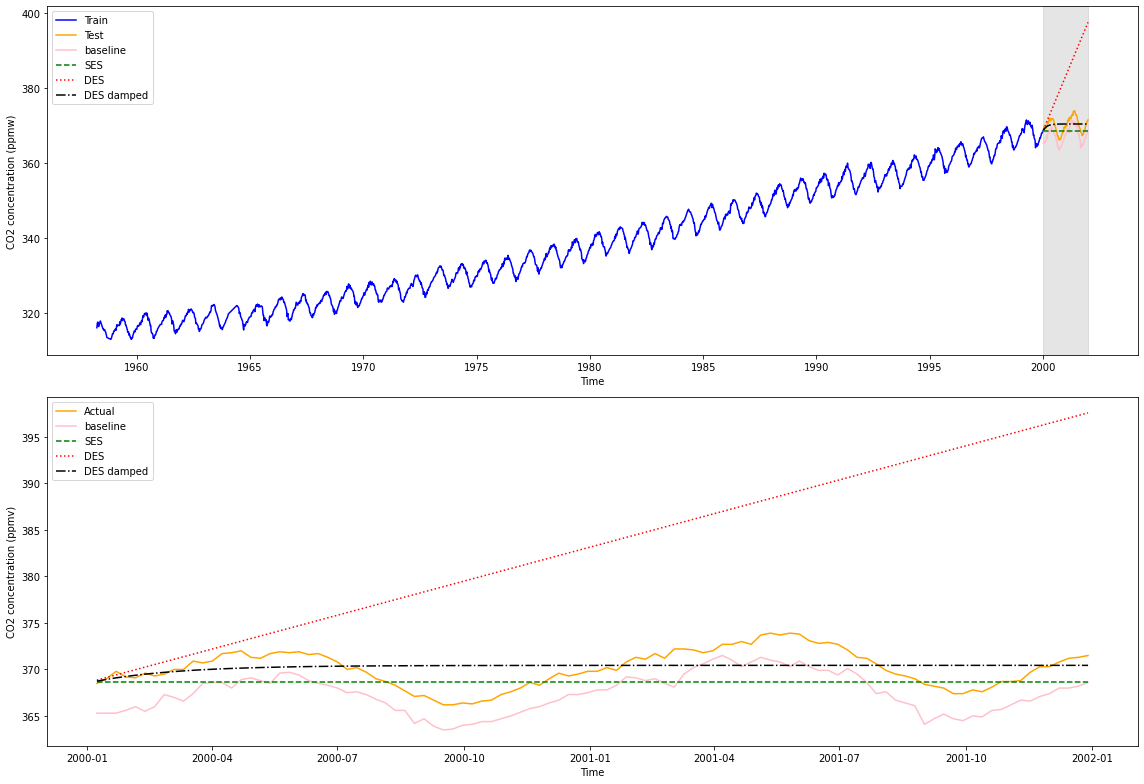

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 11))

ax1.plot(train['co2'], label='Train', color='blue')
ax1.plot(test['co2'], label='Test', color='orange')
ax1.plot(test['baseline_pred'], label='baseline', color='pink', ls='-')
ax1.plot(test['ses_pred'], label='SES', color='green', ls='--')
ax1.plot(test['des1_pred'], label='DES', color='red', ls=':')
ax1.plot(test['des2_pred'], label='DES damped', color='black', ls='-.')
ax1.legend(loc='best')
ax1.set_xlabel('Time')
ax1.set_ylabel('CO2 concentration (ppmw)')
ax1.axvspan('2000-01-08', '2001-12-29', color='#808080', alpha=0.2)

ax2.plot(test['co2'], label='Actual', color='orange')
ax2.plot(test['baseline_pred'], label='baseline', color='pink', ls='-')
ax2.plot(test['ses_pred'], label='SES', color='green', ls='--')
ax2.plot(test['des1_pred'], label='DES', color='red', ls=':')
ax2.plot(test['des2_pred'], label='DES damped', color='black', ls='-.')
ax2.legend(loc='best')
ax2.set_xlabel('Time')
ax2.set_ylabel('CO2 concentration (ppmv)')

plt.tight_layout()

In [24]:
des1_mape = mape(test['co2'], test['des1_pred'])
des_damped_mape = mape(test['co2'], test['des2_pred'])

print(f'Simple exponential smoothing: {ses_mape}$')
print(f'Double exponential smoothing: {des1_mape}%')
print(f'Double exponential smoothing (damped): {des_damped_mape}%')

Simple exponential smoothing: 0.56$
Double exponential smoothing: 3.54%
Double exponential smoothing (damped): 0.44%


### 3.4 Triple exponential smoothing (Holt-Winters) 

In [25]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

tes = ExponentialSmoothing(
    train['co2'], 
    trend='add', 
    seasonal='additive', 
    seasonal_periods=52, 
    initialization_method='estimated').fit()

In [26]:
print(f"alpha = {tes.model.params['smoothing_level']}")
print(f"beta = {tes.model.params['smoothing_trend']}")
print(f"gamma = {tes.model.params['smoothing_seasonal']}")

alpha = 0.20415166130011111
beta = 0.001421276445211251
gamma = 0.35282866675322716


In [27]:
tes_pred = tes.forecast(104)

test.loc[:, 'tes_pred'] = tes_pred

test.head()

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,co2,baseline_pred,ses_pred,des1_pred,des2_pred,tes_pred
2000-01-08,368.5,365.3,368.6,368.856000,368.744102,368.923706
2000-01-15,369.0,365.3,368.6,369.134745,368.930371,368.947830
2000-01-22,369.8,365.3,368.6,369.413490,369.096162,369.229243
2000-01-29,369.2,365.6,368.6,369.692235,369.243727,369.630772
2000-02-05,369.1,366.0,368.6,369.970980,369.375068,369.881117


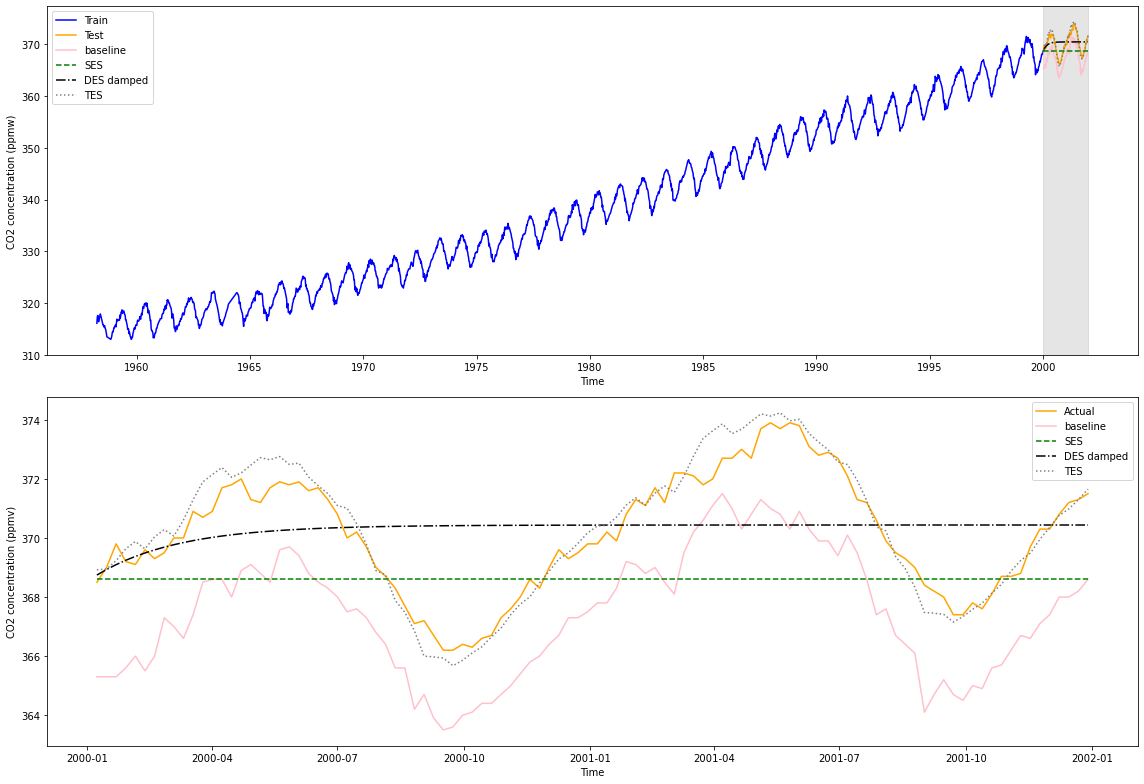

In [28]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 11))

ax1.plot(train['co2'], label='Train', color='blue')
ax1.plot(test['co2'], label='Test', color='orange')
ax1.plot(test['baseline_pred'], label='baseline', color='pink', ls='-')
ax1.plot(test['ses_pred'], label='SES', color='green', ls='--')
ax1.plot(test['des2_pred'], label='DES damped', color='black', ls='-.')
ax1.plot(test['tes_pred'], label='TES', color='grey', ls=':')
ax1.legend(loc='best')
ax1.set_xlabel('Time')
ax1.set_ylabel('CO2 concentration (ppmw)')
ax1.axvspan('2000-01-08', '2001-12-29', color='#808080', alpha=0.2)

ax2.plot(test['co2'], label='Actual', color='orange')
ax2.plot(test['baseline_pred'], label='baseline', color='pink', ls='-')
ax2.plot(test['ses_pred'], label='SES', color='green', ls='--')
ax2.plot(test['des2_pred'], label='DES damped', color='black', ls='-.')
ax2.plot(test['tes_pred'], label='TES', color='grey', ls=':')
ax2.legend(loc='best')
ax2.set_xlabel('Time')
ax2.set_ylabel('CO2 concentration (ppmv)')

plt.tight_layout()

In [29]:
tes_mape = mape(test['co2'], test['tes_pred'])

print(f'Simple exponential smoothing: {ses_mape}$')
print(f'Double exponential smoothing: {des1_mape}%')
print(f'Double exponential smoothing (damped): {des_damped_mape}%')
print(f'Triple exponential smoothing: {tes_mape}%')

Simple exponential smoothing: 0.56$
Double exponential smoothing: 3.54%
Double exponential smoothing (damped): 0.44%
Triple exponential smoothing: 0.12%


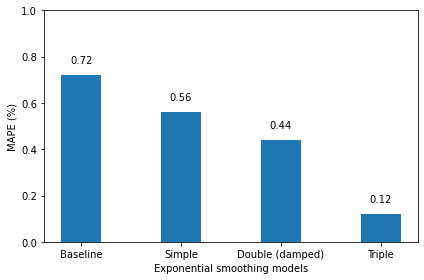

In [30]:
fig, ax = plt.subplots()

x = ['Baseline', 'Simple', 'Double (damped)', 'Triple']
y = [mape_baseline, ses_mape, des_damped_mape, tes_mape]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Exponential smoothing models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(value), ha='center')
    
plt.tight_layout()